# **Word Embeddings with Word2Vec**

Words as themselves do not offer an encoding suitable for an efficient learning algorithm.
A word is not memory efficient when being stored as a string and it does not offer any obvious measure about similarity.
Two words can differ by only one letter and still have a very different meaning, as for example "apple" and "apply".
Rather than using the words themselves as features, we can train weight vectors, which model the usage and meaning of a word.
If this weight vector is used as the embedding vector for the target word, two semantically similar words will have similar representations and small errors in training will have less impact.

### Preprocess Sentences
For our example we use 180 sentences from the label data.
Every sentence needs to be tokenized and have distinct start/ stop tokens to mark beginning and end of the sentence.

In [2]:
import pandas as pd

labels = pd.read_csv('sentences.csv', names=['sentence'])
labels.head(5)

,sentence
0,Holding something
1,Turning something upside down
2,Turning the camera left while filming something
3,Stacking number of something
4,Turning the camera right while filming something


In [3]:
def tokenize(sentence):

    if sentence is None:
        return None

    # all words to lower case:
    sentence = str.lower(sentence)

    # get rid of words in parenthesis
    while '(' in sentence:
        sentence = sentence[:sentence.find('(')] + sentence[sentence.find(')') + 2:]

    # get rid of punctuation
    sentence = ''.join(char for char in sentence if char not in '!"#$%&*+,-./:;<=>?@^_')

    # add stop token
    if sentence[len(sentence)-1] == ' ':
        sentence += u"</s>"
    else:
        sentence += u" </s>"

    # add start token
    sentence = u"<s> " + sentence

    return sentence

In [4]:
sentence_list = [tokenize(row['sentence']) for _, row in labels.iterrows()]

print(sentence_list[:5])

['<s> holding something </s>', '<s> turning something upside down </s>', '<s> turning the camera left while filming something </s>', '<s> stacking number of something </s>', '<s> turning the camera right while filming something </s>']


We also need a vocabulary containing each unique word occuring in the label sentences.

In [18]:
splits_list = [sentence.split(" ") for sentence in sentence_list]
word_list = [word for split in splits_list for word in split]
vocabulary = set(word_list)

# create dictionary from word to id and put unknown for id 0
word2id = dict(zip(vocabulary, range(1, 1 + len(vocabulary))))
word2id[u"unk"] = 0
vocabulary.add(u"unk")
# create reverse dictionary
id2word = dict(zip(word2id.values(), word2id.keys()))

print(word2id)

{'squeeze': 1, 'covering': 2, 'pushing': 3, 'along': 4, 'stacking': 5, 'for': 6, 'already': 7, 'slanted': 8, 'squeezing': 9, 'upright': 10, 'bit': 11, 'stick': 12, 'trying': 13, 'glide': 14, 'tearing': 15, 'wiping': 16, 'colliding': 17, 'up': 18, 'camera': 19, 'and': 20, 'tilting': 21, 'but': 22, "can't": 23, 'move': 24, 'starts': 25, 'spins': 26, 'plugging': 27, 'quickly': 28, 'poke': 29, 'putting': 30, 'spinning': 31, 'sprinkling': 32, 'failing': 33, 'sliding': 34, 'close': 35, 'opening': 36, 'falls': 37, 'feather': 38, 'continues': 39, 'comes': 40, 'lightly': 41, 'deforms': 42, 'it': 43, 'showing': 44, 'top': 45, 'not': 46, 'a': 47, 'hand': 48, 'take': 49, 'poking': 50, 'deflected': 51, 'twist': 52, 'until': 53, 'are': 54, 'flat': 55, 'off': 56, 'filming': 57, 'falling': 58, 'upside': 59, 'closing': 60, 'air': 61, 'rolling': 62, 'table': 63, 'underneath': 64, 'picking': 65, 'sprinkle': 66, 'little': 67, 'behind': 68, 'paper': 69, 'wipe': 70, 'being': 71, '</s>': 72, 'uncovering': 73

### Training the model
A fixed number of words before and after the target words are used as labels, in order to train the model.

![alt text](word2vec_pairs.png "Title")

In [6]:
def get_context_words(w_id, window, sentence):
    # copy list so we don't delete in place
    new_sentence = list(sentence)
    del new_sentence[w_id]
    # get the window around the now deleted word
    context_words = new_sentence[max(0, w_id - window): min(len(new_sentence), w_id + window)]
    return context_words

Instead of a softmax classifier, a simplified version of **Noise Contrastive Estimation** is applied, called **Negative Sampling**.
By using this method, the training process' complexity is being reduced from a multinomial classification problem to a binary one.
Contrary to the softmax output vector, the model just predicts if a certain word pair consisting of the target word and a label is good or bad.
For every training example the model trains an instance of the target word with the true label and a set amount of
instances of the target word with negative labels.
Instead of estimating the whole probability distribution for a target word in the output layer, with negative
sampling only a small subset of weights will be affected at once.

The examples are written into TFRecord, a TensorFlow data storage format offering both performance and integration advantages.

In [30]:
import tensorflow as tf
import numpy as np

def _write_to_tfr(sentence_list, train_filename, skip_window, dictionary):
    splits_list = [sentence.split(" ") for sentence in sentence_list]
    lowercase_splits_list = [[str.lower(word) for word in sentence] for sentence in splits_list]
    encoded_splits_list = [[dictionary[word] for word in sentence] for sentence in lowercase_splits_list]
    example_size = 0
    with tf.python_io.TFRecordWriter(train_filename) as writer:
        for sentence in encoded_splits_list:
            for i, word in enumerate(sentence):
                context_words = get_context_words(i, skip_window, sentence)
                for c_word in context_words:
                    # one example consists of the input word and one of the context words around it
                    feature = {'word': tf.train.Feature(int64_list=tf.train.Int64List(value=[word])),
                               'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[c_word]))}
                    example = tf.train.Example(features=tf.train.Features(feature=feature))
                    writer.write(example.SerializeToString())
                    example_size += 1
    return example_size

In [12]:
train_example_size = _write_to_tfr(sentence_list, 'word2vec_examples', 1, word2id)

The model function itself returns an estimator to optimize.

In [14]:
def _word2vec_model_fn(features, labels, mode, params):

    # get parameters
    num_neg_samples = params['num_neg_samples']
    embed_size = params['embedding_size']
    vocab_size = params['vocabulary_size']

    # initialize random embedding vectors and embed input
    initial_width = 0.5 / embed_size
    embeddings = tf.Variable(
        tf.random_uniform([vocab_size, embed_size], -initial_width, initial_width), name='embedding')

    if mode == tf.estimator.ModeKeys.PREDICT:
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
        normalized_embeddings = embeddings / norm

        predictions = {
            'final_embedding': normalized_embeddings
        }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # get current embedding for input
    embed = tf.nn.embedding_lookup(embeddings, features)

    # initialize weights and biases for noise contrast estimation
    nce_weights = tf.Variable(
        tf.truncated_normal([vocab_size, embed_size],
                            stddev=1.0 / np.sqrt(embed_size)))
    nce_biases = tf.Variable(tf.zeros([vocab_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative ws each
    # time we evaluate the loss.
    loss = tf.reduce_mean(
        tf.nn.nce_loss(weights=nce_weights,
                       biases=nce_biases,
                       labels=tf.reshape(labels, [-1, 1]),
                       inputs=embed,
                       num_sampled=num_neg_samples,
                       num_classes=vocab_size))

    # create training op.
    assert mode == tf.estimator.ModeKeys.TRAIN

    # doing gradient descent
    train_op = tf.train.GradientDescentOptimizer(1.0).minimize(loss, global_step=tf.train.get_global_step())

    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

In [19]:
vocabulary_size = len(vocabulary)

# set the classifier
classifier = tf.estimator.Estimator(
    model_fn=_word2vec_model_fn,
    model_dir='.',
    params={'num_neg_samples': 64,
            'embedding_size': 128,
            'vocabulary_size': vocabulary_size
            }
)

low_dim_embs = None

labels = [id2word[i] for i in range(vocabulary_size)]


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '.', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f64d2ebacd0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Input functions for training and evaluation.

In [22]:
def _parse_tfr_data(example):
    keys_to_features = {'word': tf.FixedLenFeature((), tf.int64, default_value=0),
                        'label': tf.FixedLenFeature((), tf.int64, default_value=0)}
    parsed_features = tf.parse_single_example(example, keys_to_features)

    return parsed_features['word'], parsed_features['label']

In [23]:
def _train_input_fn(tfrecord_filename, train_batch_size, train_epochs, seed=None):
    data_set = tf.data.TFRecordDataset(tfrecord_filename)
    data_set = data_set.map(_parse_tfr_data)
    shuffeled_data_set = data_set.shuffle(1000, seed=seed)
    epochd_data_set = shuffeled_data_set.repeat(train_epochs)
    batched_dataset = epochd_data_set.batch(train_batch_size)
    return batched_dataset

In [24]:
def _eval_input_fn(features, labels, eval_batch_size):
    features = dict(features)
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)
    data_set = tf.data.Dataset.from_tensor_slices(inputs)
    data_set = data_set.batch(eval_batch_size)
    return data_set

In [25]:
def _evaluate(vocabulary_size, classifier, id2word):
    num_eval_words = 20
    max_eval_id = vocabulary_size
    valid_examples = list(np.random.choice(max_eval_id, num_eval_words, replace=False))
    valid_data = {'eval_words': valid_examples}

    # get predictions
    predicted_embeddings = classifier.predict(
        input_fn=lambda: _eval_input_fn(valid_data, labels=None, eval_batch_size=num_eval_words))
    final_embedding = []
    for i, embedding in enumerate(predicted_embeddings):
        final_embedding.append(embedding['final_embedding'])
        if i == vocabulary_size - 1:
            break

    embedding_array = np.array(final_embedding)

    return embedding_array

To visualize the embeddings we reduce the dimensions with t-Sne

In [42]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def _plot_tsne(embeddings, labels, epoch):
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    low_dim_embs = tsne.fit_transform(embeddings)
    _plot_with_labels(low_dim_embs, labels)

    return low_dim_embs

def _plot_with_labels(low_dim_embs, labels):
    plt.figure(figsize=(18, 18))
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.show()
    
def _plot_trace_with_labels(start_emb, end_emb, labels):
    plt.figure(figsize=(18, 18))
    for i, label in enumerate(labels):
        x, y = end_emb[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    for i in range(len(labels)):
        x, y = start_emb[i, :]
        new_x, new_y = end_emb[i, :]
        plt.plot([x, new_x], [y, new_y], color='r')
    plt.show()

def _plot_tsne(embeddings, labels, epoch):
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
    low_dim_embs = tsne.fit_transform(embeddings)
    _plot_with_labels(low_dim_embs, labels)

    return low_dim_embs

INFO:tensorflow:Could not find trained model in model_dir: ., running initialization to predict.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


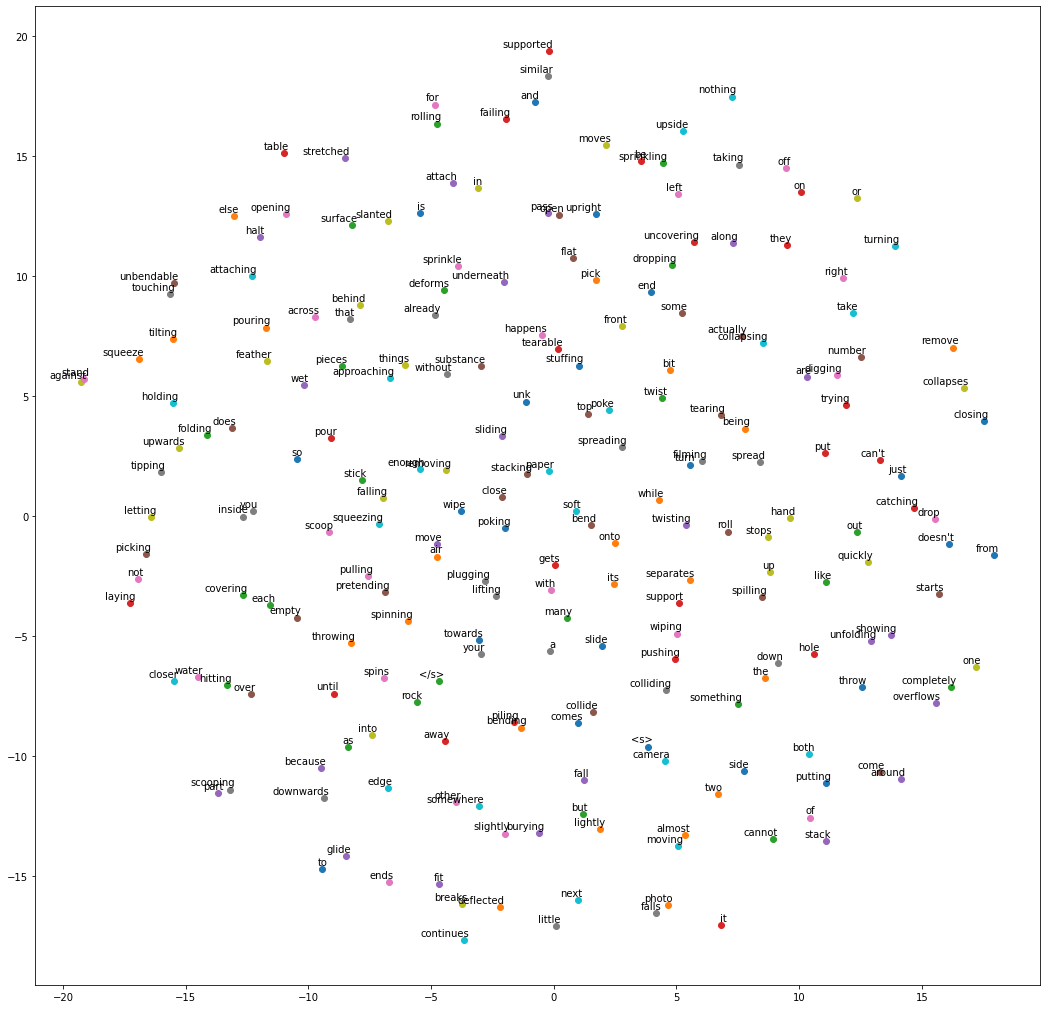

In [43]:
embeddings = _evaluate(vocabulary_size, classifier, id2word)
start_emb = _plot_tsne(embeddings, labels, 0)

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./model.ckpt.
INFO:tensorflow:loss = 93.4498, step = 1
INFO:tensorflow:global_step/sec: 200.198
INFO:tensorflow:loss = 4.3369474, step = 101 (0.500 sec)
INFO:tensorflow:global_step/sec: 249.582
INFO:tensorflow:loss = 3.1249216, step = 201 (0.400 sec)
INFO:tensorflow:global_step/sec: 284.673
INFO:tensorflow:loss = 3.4817824, step = 301 (0.352 sec)
INFO:tensorflow:global_step/sec: 254.568
INFO:tensorflow:loss = 3.3510811, step = 401 (0.393 sec)
INFO:tensorflow:global_step/sec: 293.989
INFO:tensorflow:loss = 3.1385467, step = 501 (0.340 sec)
INFO:tensorflow:global_step/sec: 248.783
INFO:tensorflow:loss = 3.2465959, step = 601 (0.402 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:global_step/sec: 269.337
INFO:tensorflow:loss = 2.4786615, step = 7801 (0.373 sec)
INFO:tensorflow:global_step/sec: 239.419
INFO:tensorflow:loss = 2.3303277, step = 7901 (0.416 sec)
INFO:tensorflow:global_step/sec: 240.797
INFO:tensorflow:loss = 2.265697, step = 8001 (0.416 sec)
INFO:tensorflow:global_step/sec: 241.449
INFO:tensorflow:loss = 2.1876228, step = 8101 (0.420 sec)
INFO:tensorflow:global_step/sec: 232.774
INFO:tensorflow:loss = 3.3051424, step = 8201 (0.424 sec)
INFO:tensorflow:global_step/sec: 269.849
INFO:tensorflow:loss = 2.0733752, step = 8301 (0.373 sec)
INFO:tensorflow:global_step/sec: 282.496
INFO:tensorflow:loss = 2.570244, step = 8401 (0.354 sec)
INFO:tensorflow:global_step/sec: 255.265
INFO:tensorflow:loss = 2.9550455, step = 8501 (0.390 sec)
INFO:tensorflow:global_step/sec: 187.343
INFO:tensorflow:loss = 2.5211103, step = 8601 (0.534 sec)
INFO:tensorflow:global_step/sec: 263.527
INFO:tensorflow:loss = 2.3912995, step = 8701 (0.380 sec)
INFO:tensorf

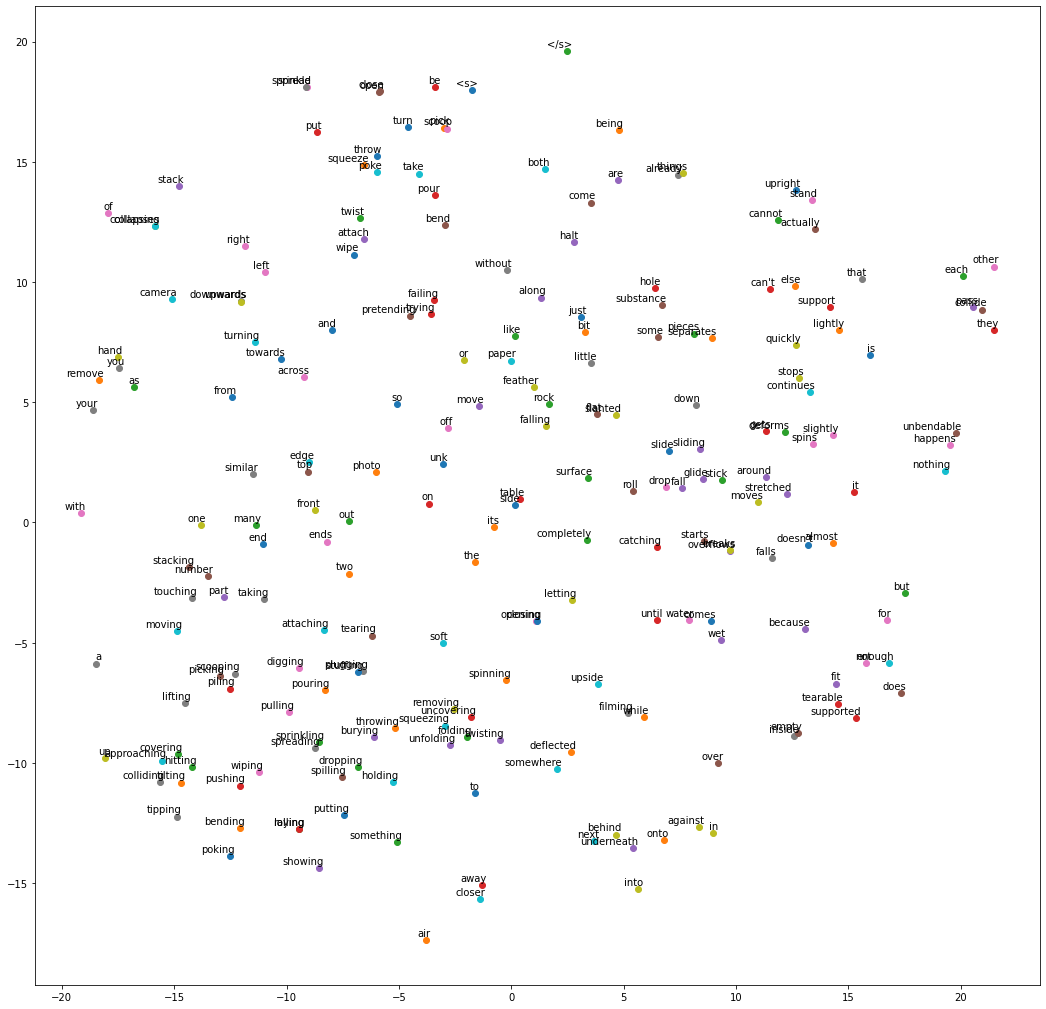

In [45]:
classifier.train(input_fn=lambda: _train_input_fn(
    'word2vec_examples', 100, np.ceil(500 / 2)))

embeddings = _evaluate(vocabulary_size, classifier, id2word)
low_dim_embs = _plot_tsne(embeddings, labels, epoch)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./model.ckpt-11710
Instructions for updating:
Use standard file utilities to get mtimes.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 11710 into ./model.ckpt.
INFO:tensorflow:loss = 3.5658133, step = 11711
INFO:tensorflow:global_step/sec: 199.287
INFO:tensorflow:loss = 2.4076765, step = 11811 (0.503 sec)
INFO:tensorflow:global_step/sec: 287.359
INFO:tensorflow:loss = 2.0434034, step = 11911 (0.347 sec)
INFO:tensorflow:global_step/sec: 156.694
INFO:tensorflow:loss = 3.7567146, step = 12011 (0.638 sec)
INFO:tensorflow:global_step/sec: 253.757
INFO:tensorflow:loss = 3.9187005, step = 12111 (0.394 sec)
INFO:tensorflow:global_step/sec: 259.568
INFO:tensorflow:loss = 2.7460086, step = 12211 (0.386 sec)
INFO:tensorflow:globa

INFO:tensorflow:global_step/sec: 124.771
INFO:tensorflow:loss = 2.3868055, step = 19311 (0.809 sec)
INFO:tensorflow:global_step/sec: 141.382
INFO:tensorflow:loss = 2.3916373, step = 19411 (0.698 sec)
INFO:tensorflow:global_step/sec: 287.811
INFO:tensorflow:loss = 2.0683668, step = 19511 (0.347 sec)
INFO:tensorflow:global_step/sec: 291.833
INFO:tensorflow:loss = 2.0470812, step = 19611 (0.343 sec)
INFO:tensorflow:global_step/sec: 286.671
INFO:tensorflow:loss = 2.154709, step = 19711 (0.349 sec)
INFO:tensorflow:global_step/sec: 299.857
INFO:tensorflow:loss = 1.8688313, step = 19811 (0.334 sec)
INFO:tensorflow:global_step/sec: 265.987
INFO:tensorflow:loss = 2.6050375, step = 19911 (0.376 sec)
INFO:tensorflow:global_step/sec: 286.498
INFO:tensorflow:loss = 2.4837263, step = 20011 (0.349 sec)
INFO:tensorflow:global_step/sec: 290.67
INFO:tensorflow:loss = 2.2599769, step = 20111 (0.344 sec)
INFO:tensorflow:global_step/sec: 282.488
INFO:tensorflow:loss = 2.2907739, step = 20211 (0.356 sec)
IN

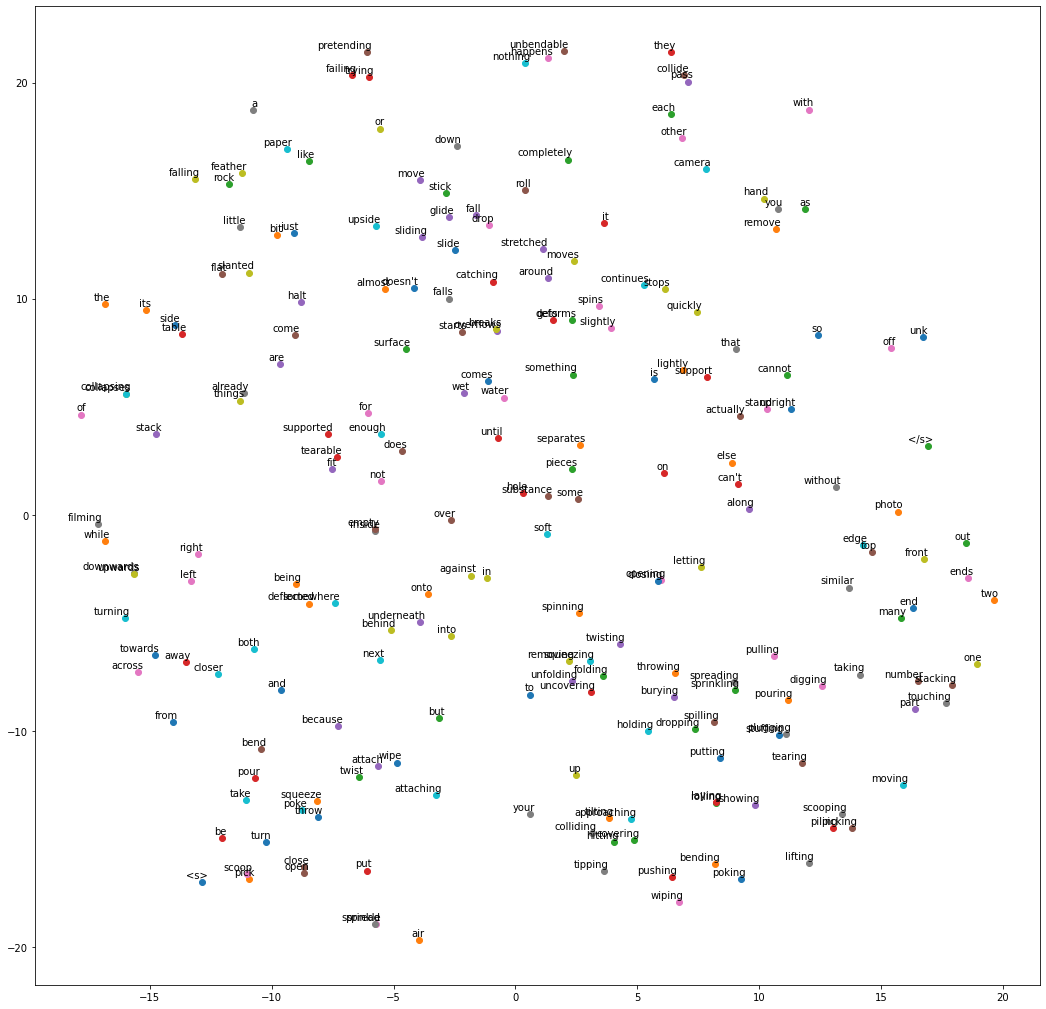

In [47]:
classifier.train(input_fn=lambda: _train_input_fn(
    'word2vec_examples', 100, np.ceil(500 / 2)))

embeddings = _evaluate(vocabulary_size, classifier, id2word)
low_dim_embs = _plot_tsne(embeddings, labels, epoch)

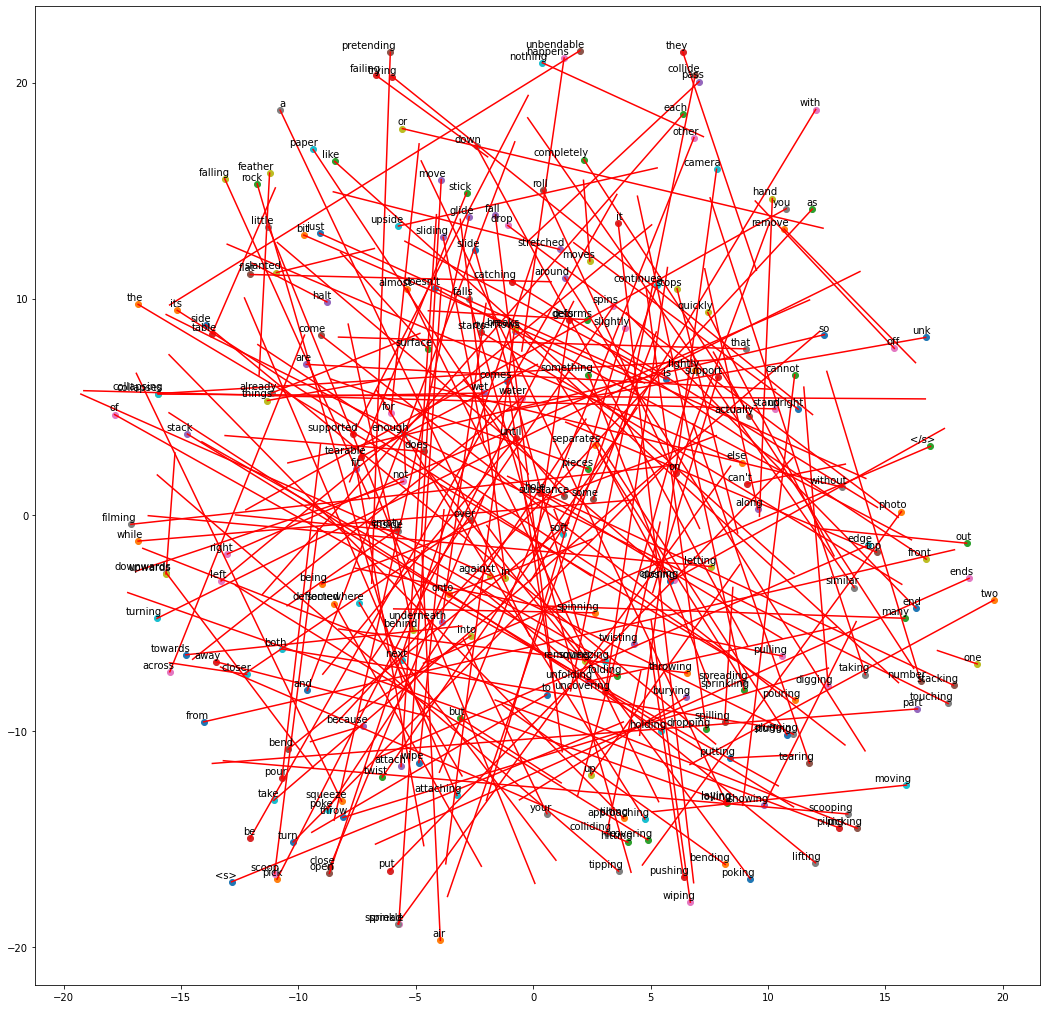

In [49]:
_plot_trace_with_labels(start_emb, low_dim_embs, labels)